Epochs: 20
Batch size: 128
Batches per epoch: 468


/Users/nurlanabzalbekov/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


  0%|          | 0/20 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


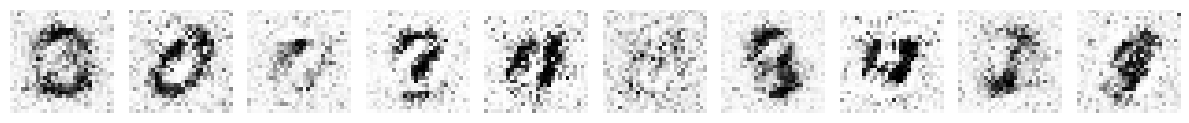

--------------- Epoch 5 ---------------


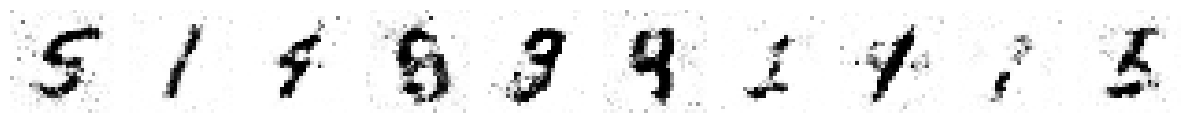

--------------- Epoch 10 ---------------


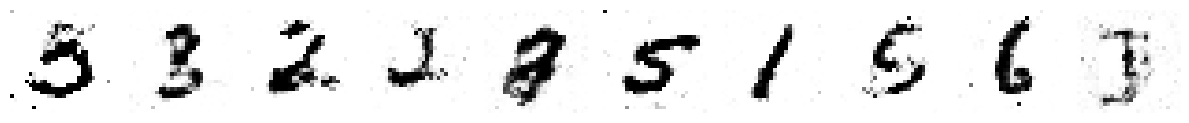

--------------- Epoch 15 ---------------


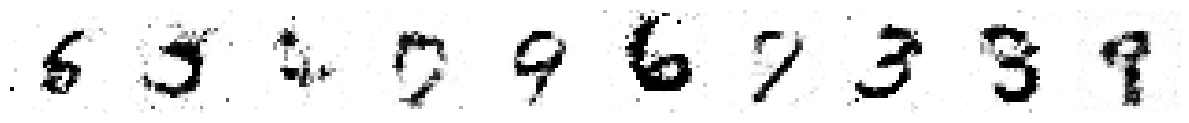

--------------- Epoch 20 ---------------


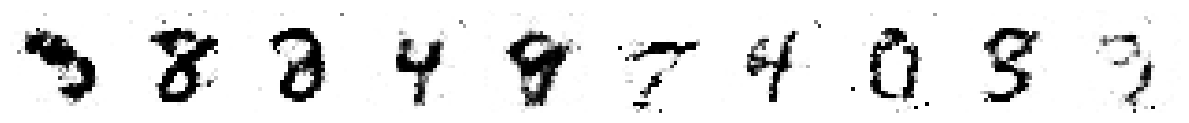

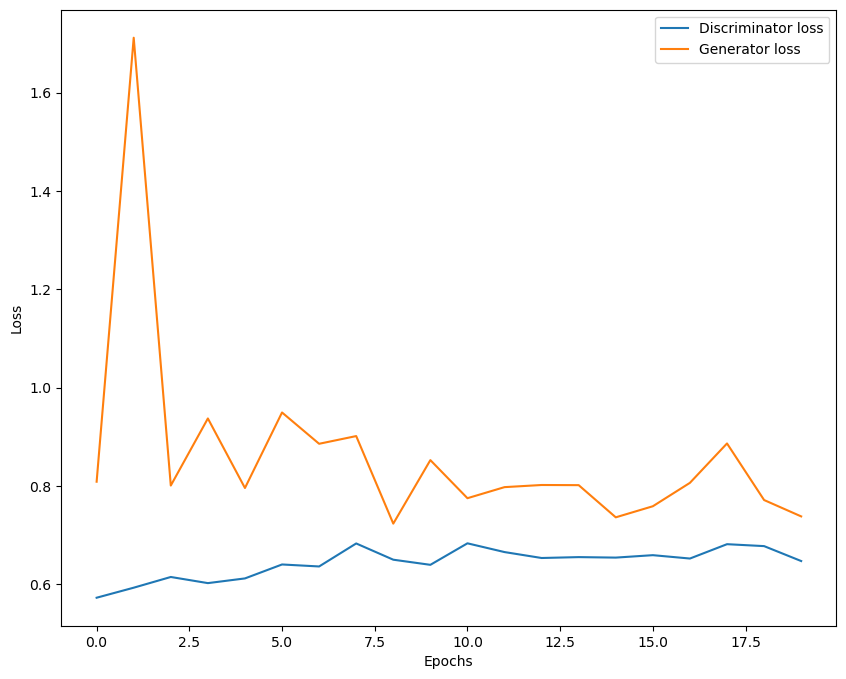

In [2]:
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, LeakyReLU, BatchNormalization
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

#MNIST Dataset
(X_train, _), (_, _) = mnist.load_data()
X_train = X_train.reshape(60000, 784).astype('float32') / 127.5 - 1  # Normalize between -1 and 1

z_dim = 100

adam = Adam(lr=0.0004, beta_1=0.5)

# Generator
g = Sequential()
g.add(Dense(256, input_dim=z_dim))
g.add(LeakyReLU(0.2))
g.add(BatchNormalization(momentum=0.8))
g.add(Dense(512))
g.add(LeakyReLU(0.2))
g.add(BatchNormalization(momentum=0.8))
g.add(Dense(1024))
g.add(LeakyReLU(0.2))
g.add(BatchNormalization(momentum=0.8))
g.add(Dense(784, activation='tanh'))

# Discriminator
d = Sequential()
d.add(Dense(1024, input_dim=784))
d.add(LeakyReLU(0.2))
d.add(Dropout(0.3))
d.add(Dense(512))
d.add(LeakyReLU(0.2))
d.add(Dropout(0.3))
d.add(Dense(256))
d.add(LeakyReLU(0.2))
d.add(Dropout(0.3))
d.add(Dense(1, activation='sigmoid'))
d.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

# GAN
d.trainable = False
inputs = Input(shape=(z_dim,))
hidden = g(inputs)
output = d(hidden)
gan = Model(inputs, output)
gan.compile(loss='binary_crossentropy', optimizer=adam)

# Visualization
def plot_loss(losses):
    d_loss = [v[0] for v in losses["D"]]
    g_loss = [v for v in losses["G"]]
    plt.figure(figsize=(10, 8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_generated(n_ex=10, dim=(1, 10), figsize=(12, 2)):
    noise = np.random.normal(0, 1, size=(n_ex, z_dim))
    generated_images = g.predict(noise, verbose=0)
    generated_images = generated_images.reshape(n_ex, 28, 28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Training phase
losses = {"D": [], "G": []}

def train(epochs=1, plt_frq=1, BATCH_SIZE=128):
    batch_count = int(X_train.shape[0] / BATCH_SIZE)
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batch_count)

    for e in tqdm(range(1, epochs + 1)):
        if e == 1 or e % plt_frq == 0:
            print('-' * 15, 'Epoch %d' % e, '-' * 15)
        for _ in range(batch_count):
            # real images
            idx = np.random.randint(0, X_train.shape[0], BATCH_SIZE)
            real_images = X_train[idx]

            # fake images
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            fake_images = g.predict(noise, verbose=0)

            # Combine real and fake images
            X = np.concatenate([real_images, fake_images])

            # Labeling images
            y_dis = np.zeros(2 * BATCH_SIZE)
            y_dis[:BATCH_SIZE] = 1  # Real images label

            # Discriminator training
            d_loss = d.train_on_batch(X, y_dis)

            # Generator training
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            y_gen = np.ones(BATCH_SIZE)  # The generator wants the discriminator to output 1
            g_loss = gan.train_on_batch(noise, y_gen)

        # Losses
        losses["D"].append(d_loss)
        losses["G"].append(g_loss)

        # Plotting
        if e == 1 or e % plt_frq == 0:
            plot_generated()

    plot_loss(losses)

train(epochs=20, plt_frq=5, BATCH_SIZE=128)
